# 1.3.1 IterativeGaussianization

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

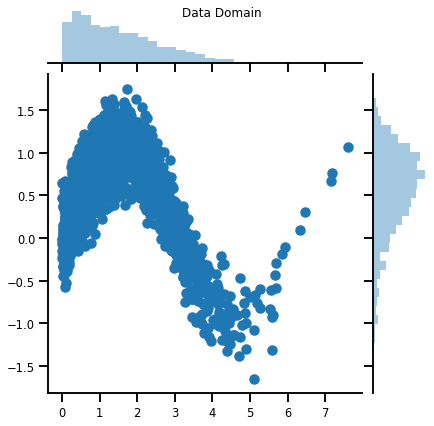

In [2]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.suptitle('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [3]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Histogram Uniformization

In [4]:
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.kde import InitKDEUniformize

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

In [5]:
support_extension = 10
bw = 0.1
precision = 100

# initialize histogram transformation
uni_uniformize = InitKDEUniformize(
    n_samples=X.shape[0],
    support_extension=support_extension,
    precision=precision,
    bw=bw
)

In [6]:
X.shape

(2000, 2)

In [7]:
X_u, params = uni_uniformize[0](X[:, 0])

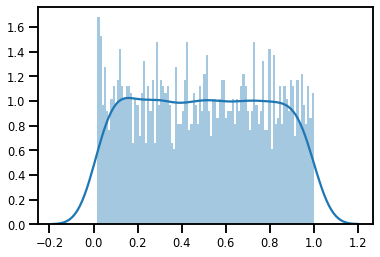

In [8]:
plt.figure()
sns.distplot(X_u, bins=100)
plt.show()

### Rotation

In [16]:
from rbig_jax.transforms.rotation import InitPCARotation

# initialize rotation transformation
rot_transform = InitPCARotation()

In [17]:
X_r, params = rot_transform[0](X)

<Figure size 432x288 with 0 Axes>

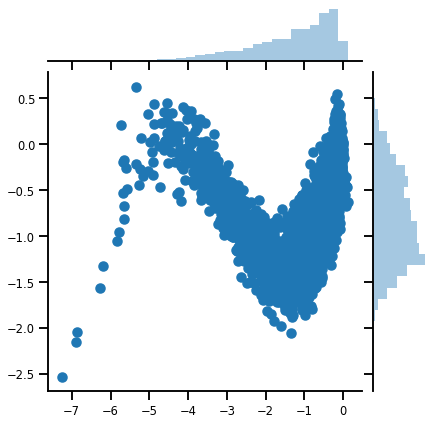

In [18]:
plt.figure()
sns.jointplot(X_r[:, 0], X_r[:, 1])
plt.show()

### Marginal Gaussianization

In [19]:
from typing import Union, Callable
from rbig_jax.utils import get_domain_extension

import chex
from chex import Array

@chex.dataclass
class RBIGParams:
    support: Array
    quantiles: Array
    support_pdf: Array
    empirical_pdf: Array
    rotation: Array
        
        
def marginal_fit_transform(X, f: Callable):
    X, params = jax.vmap(f, out_axes=(0, 0))(X.T)
    return X.T, params

def marginal_transform(X, f: Callable, params):
    X = jax.vmap(f, in_axes=(0, 0), out_axes=1)(params, X.T)
    return X



def InitRBIG(
    uni_uniformize: Callable,
    rot_transform: Callable,
    eps: float = 1e-5
):
    # unpack functions
    uni_init_f, uni_forward_f, uni_grad_f, uni_inverse_f = uni_uniformize
    rot_init_f, rot_forward_f, rot_grad_f, rot_inverse_f = rot_transform
    
    # create marginal functions
    
    # TODO a bin initialization function
    def init_func(inputs):
        
        # marginal uniformization
        inputs, uni_params = marginal_fit_transform(inputs, uni_init_f)
        
        # regularization for boundaries
        inputs = np.clip(inputs, eps, 1 - eps)
        
        # inverse gaussian CDF
        inputs = jax.scipy.stats.norm.ppf(inputs)
        
        # rotation
        outputs, rot_params = rot_init_f(inputs)
        
        # initialize new RBiG params
        params = RBIGParams(
            support=uni_params.support, 
            quantiles=uni_params.quantiles, 
            empirical_pdf=uni_params.empirical_pdf, 
            support_pdf=uni_params.support_pdf, 
            rotation=rot_params.rotation
        )
        
        return outputs, params
    
    def transform(params, inputs):
        
        inputs = marginal_transform(inputs, uni_forward_f, params)
        
        inputs = np.clip(inputs, eps, 1 - eps)

        inputs = jax.scipy.stats.norm.ppf(inputs)
        
        # rotation
        outputs = rot_forward_f(params, inputs)
        
        return outputs

    def gradient_transform(params, inputs):
        
        # Log PDF of normalized data
        absdet = marginal_transform(inputs, uni_grad_f, params)
        
        logabsdet = np.log(absdet)
        
        # forward uniformization function        
        inputs = marginal_transform(inputs, uni_forward_f, params)
        
        # clip boundaries
        inputs = np.clip(inputs, eps, 1 - eps)
        
        # inverse cdf
        inputs = jax.scipy.stats.norm.ppf(inputs)
        
        # Log PDF for Gaussianized data
        logabsdet =  logabsdet - jax.scipy.stats.norm.logpdf(inputs)
        
        # rotation is zero...
        outputs = rot_forward_f(params, inputs)

        return outputs, logabsdet

    def inverse_transform(params, inputs):
        
        # rotation
        inputs = rot_inverse_f(params, inputs)
        
        # inverse gaussian cdf
        inputs = jax.scipy.stats.norm.cdf(inputs)
        
        # marginal uniformization
        outputs = marginal_transform(inputs, uni_inverse_f, params)
        
        return outputs
        
    
    return init_func, transform, gradient_transform, inverse_transform

In [20]:
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))

# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize marginal gaussianization
eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = InitRBIG(uni_uniformize, rot_transform, eps)

### Fit Forward Function

In [21]:
X_g, params = fit_transform_func(X)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


<Figure size 432x288 with 0 Axes>

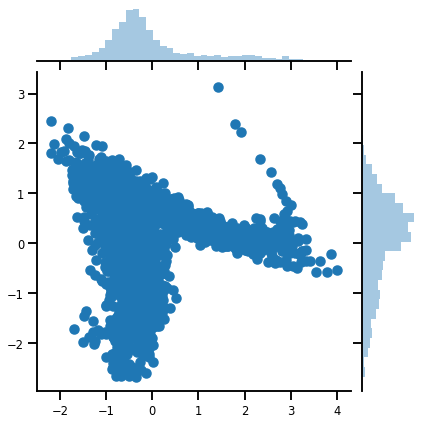

In [22]:
plt.figure()
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()

#### Jitted

In [23]:
fit_transform_func_jitted = jax.jit(fit_transform_func)

In [109]:
_ = fit_transform_func_jitted(X) 
%timeit fit_transform_func(X.block_until_ready())
%timeit fit_transform_func_jitted(X.block_until_ready()) 

192 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
531 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Forward Transformation

In [24]:
X_g = forward_f(params, X)

<Figure size 432x288 with 0 Axes>

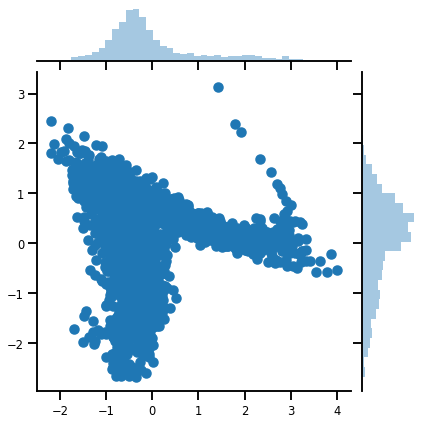

In [25]:
plt.figure()
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()

### Inverse Transformation

In [26]:
X_approx = inverse_f(params, X_g)

<Figure size 432x288 with 0 Axes>

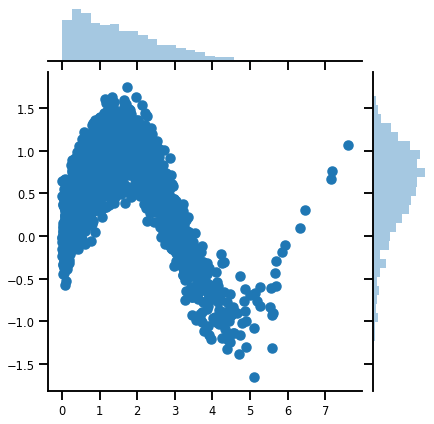

In [27]:
plt.figure()
sns.jointplot(X_approx[:, 0], X_approx[:, 1])
plt.show()

In [28]:
chex.assert_tree_all_close(X_approx, X, rtol=1e-3)

### Gradient Transformation

In [29]:
X_g_, X_ldj = grad_f(params, X)

TypeError: log requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [ ]:
chex.assert_tree_all_close(X_g_, X_g)

In [30]:
plt.figure()
sns.jointplot(X_ldj[:, 0], X_ldj[:, 1])
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()

NameError: name 'X_ldj' is not defined

<Figure size 432x288 with 0 Axes>

## Iterative Stopping Criteria

#### Information Reduction

## Multiple Iterations

In [128]:
fit_transform_func, forward_f, grad_f, inverse_f = InitRBIG(uni_uniformize, rot_transform, eps)
fit_transform_func_jitted = jax.jit(fit_transform_func)


In [197]:
%%time
n_samples = 10_000
data = get_classic(n_samples)

X = np.array(data, dtype=np.float32)



params = []
losses = []

n_layers = 30
ilayer = 0


X_g = X
while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)    

CPU times: user 2.53 s, sys: 19.5 ms, total: 2.55 s
Wall time: 2.53 s


In [198]:
X_g.dtype

dtype('float32')

<Figure size 432x288 with 0 Axes>

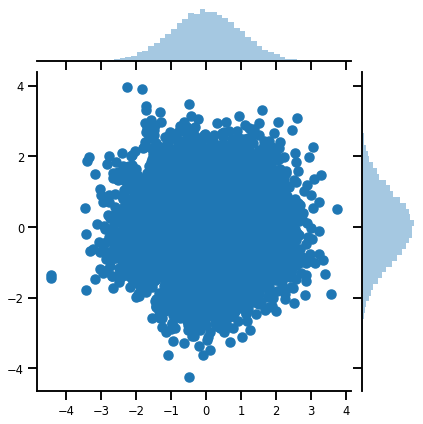

In [199]:
plt.figure()
sns.jointplot(X_g[:, 0], X_g[:, 1])
plt.show()

#### Jit w/ Scan Function

In [200]:
def f_fit_transform(inputs, i):
    return fit_transform_func(inputs)

In [201]:
X_g.dtype

dtype('float32')

In [134]:
X_g = X
%timeit jax.lax.scan(f_fit_transform, X_g.block_until_ready(), None, n_layers)

2.96 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [202]:
%%time
X_g = X
X_g, layer_params = jax.lax.scan(f_fit_transform, X_g.block_until_ready(), None, n_layers)

CPU times: user 3.54 s, sys: 23.4 ms, total: 3.57 s
Wall time: 3.56 s


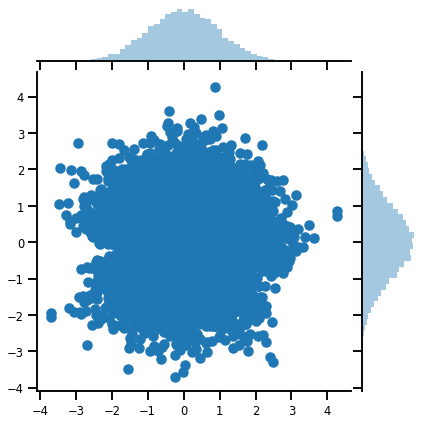

In [203]:
# plt.figure(figsize=(3,3))
sns.jointplot(X_g[:, 0], X_g[:, 1])
# plt.show()

### Forward

In [204]:
def f_apply(inputs, params):
    
    outputs = forward_f(params, inputs)
    return outputs, 0

In [138]:
X_g = X
%timeit jax.lax.scan(f_apply, X_g.block_until_ready(), layer_params, None)

435 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [205]:
%%time
X_g = X
X_g, _ = jax.lax.scan(f_apply, X_g.block_until_ready(), layer_params, None)

CPU times: user 492 ms, sys: 955 µs, total: 493 ms
Wall time: 490 ms


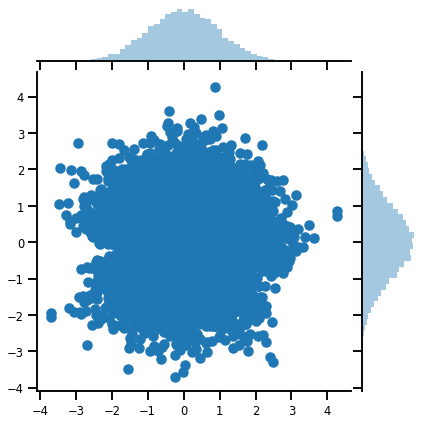

In [206]:
sns.jointplot(X_g[:, 0], X_g[:, 1])

### Inverse

In [207]:
def f_invapply(inputs, params):
    
    outputs = inverse_f(params, inputs)
    return outputs, 0

In [208]:
layer_params_reversed = jax.tree_map(lambda x: x[::-1], layer_params)

In [143]:
X_approx = X_g
%timeit jax.lax.scan(f_invapply, X_approx.block_until_ready(), layer_params_reversed, None)

537 ms ± 8.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [209]:
X_approx = X_g
X_approx, _ = jax.lax.scan(f_invapply, X_approx.block_until_ready(), layer_params_reversed, None)

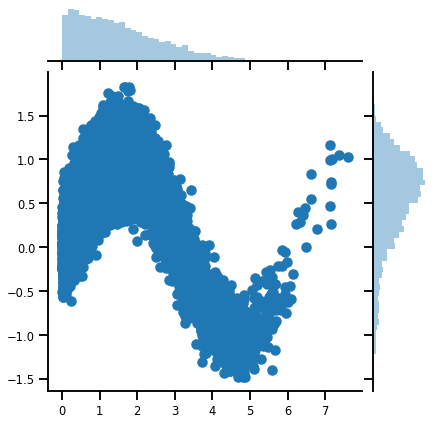

In [210]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1])

### Gradient

In [211]:
def fscan_gradient(inputs, params):
    return grad_f(params, inputs)

In [147]:
X_g = X
%timeit jax.lax.scan(fscan_gradient, X_g.block_until_ready(), layer_params, None)

807 ms ± 20.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [212]:
%%time

X_g = X
X_g, X_ldj = jax.lax.scan(fscan_gradient, X_g.block_until_ready(), layer_params, None)

CPU times: user 905 ms, sys: 7.65 ms, total: 913 ms
Wall time: 908 ms


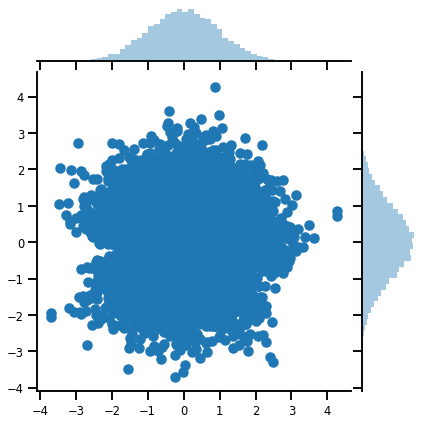

In [213]:
sns.jointplot(X_g[:, 0], X_g[:, 1])

### Probabilities

In [6]:
latent_prob = jax.scipy.stats.norm.logpdf(X_g)

log_prob = (latent_prob + X_ldj.sum(axis=0)).sum(-1)

NameError: name 'X_g' is not defined

In [7]:
cmap = "Reds"
probs = log_prob
# probs = np.clip(probs, 0.0, 1.0)
probs = np.clip(probs, None, 0.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(X[:, 0], X[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

NameError: name 'log_prob' is not defined

In [5]:
cmap = "Reds"
probs = np.exp(log_prob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
fig.save_fig("./itergauss_prob.png")
plt.tight_layout()

NameError: name 'log_prob' is not defined

### Log Likelihood

In [218]:
nll = -(latent_prob + X_ldj.sum(axis=0)).sum(1).mean()
print(nll)

1.4256538


In [60]:
from rbig_jax.information.entropy import histogram_entropy
from rbig_jax.information.total_corr import information_reduction, get_tolerance_dimensions

# univariate entropy estimator
nbins = int(np.sqrt(n_samples))   # important parameter
entropy_est = jax.partial(histogram_entropy, nbins=nbins, base=2)

# information reduction
tol_dims = get_tolerance_dimensions(n_samples)
loss_f = jax.partial(
    information_reduction,
    uni_entropy=entropy_est, 
    tol_dims=tol_dims,
    p=0.25
)
loss_f_jitted = jax.jit(loss_f)  # much faster!

ImportError: cannot import name 'get_params_marginal' from 'rbig_jax.transforms.marginal' (/home/emmanuel/code/rbig_jax/rbig_jax/transforms/marginal.py)

<Figure size 432x288 with 0 Axes>

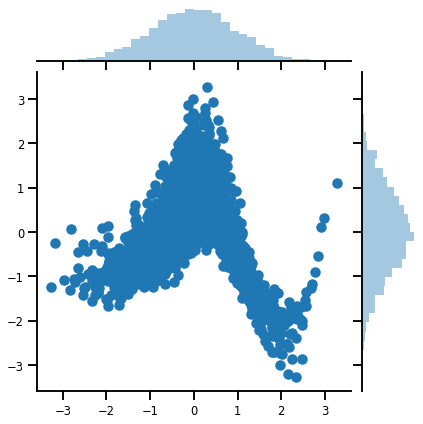

In [67]:
plt.figure()
sns.jointplot(X[:, 0], X[:, 1])
plt.show()

#### Demo

In [27]:
%%time

data = get_classic(n_samples)

X = np.array(data, dtype=np.float32)

fit_transform_func_jitted = jax.jit(fit_transform_func)

params = []
losses = []

n_layers = 20
ilayer = 0

while ilayer < n_layers:
    
    info_reduction = jax.partial(loss_f_jitted, X=X)
    
    # compute 
    X, layer_params = rbig_block_jitted(X)
    
    loss = info_reduction(Y=X)
    
    # increment
    ilayer += 1
    
    params.append(layer_params)
    losses.append(loss)
    

CPU times: user 5.53 s, sys: 5.76 s, total: 11.3 s
Wall time: 4.03 s


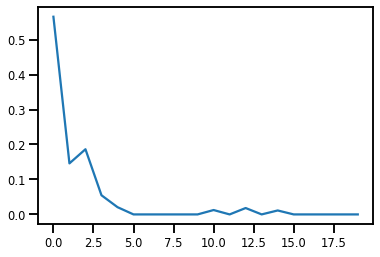

In [28]:
plt.plot(np.array(losses))

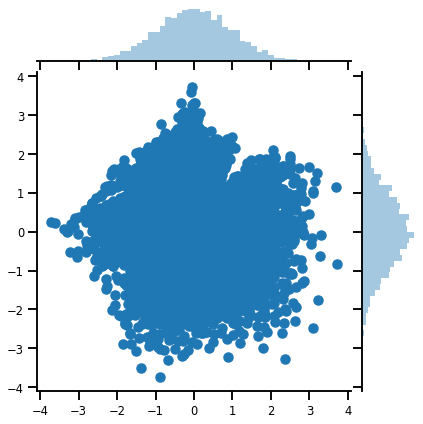

In [29]:
sns.jointplot(X[:, 0], X[:, 1])

### Forward Transformation

In [30]:
len(params)

20

In [31]:
%%time

data = get_classic(n_samples)

Xtrans = np.array(data)


# initialize transformation
rbig_block_transform_jitted = jax.jit(rbig_block_transform)

for ilayer_param in tqdm.tqdm(params):
    Xtrans = rbig_block_transform_jitted(Xtrans, ilayer_param)
#     sns.jointplot(X_trans[:, 0], X_trans[:, 1])
    

100%|██████████| 20/20 [00:00<00:00, 62.88it/s]

CPU times: user 335 ms, sys: 5.49 ms, total: 340 ms
Wall time: 323 ms


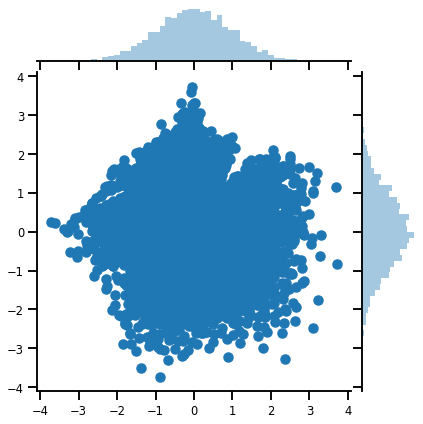

In [32]:
sns.jointplot(Xtrans[:, 0], Xtrans[:, 1])

### Inverse Transformation

In [33]:
%%time

n_layers = 1_000
layer_params = []

X_approx = np.array(Xtrans)

# initialize transformation
rbig_block_inverse_jitted = jax.jit(rbig_block_inverse)

for ilayer_param in tqdm.tqdm(params[::-1]):
    X_approx = rbig_block_inverse_jitted(X_approx, ilayer_param)
#     sns.jointplot(X_trans[:, 0], X_trans[:, 1])

100%|██████████| 20/20 [00:00<00:00, 50.37it/s]

CPU times: user 412 ms, sys: 4.78 ms, total: 417 ms
Wall time: 400 ms


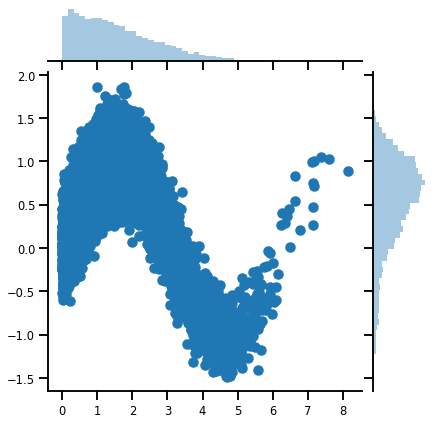

In [34]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1])

### Gradient Transformation

In [48]:

n_layers = 1_000
layer_params = []

Xtrans = np.array(data)
X_ldj = np.zeros_like(Xtrans)

def nll(X, X_ldj):
    latent_prob = jax.scipy.stats.norm.logpdf(X)

    return (latent_prob + X_ldj).sum(-1).mean()

nll_losses = []
# initialize transformation
rbig_block_transform_gradient_jitted = jax.jit(rbig_block_transform_gradient)
# rbig_block_transform_gradient_jitted = rbig_block_transform_gradient

for ilayer_param in tqdm.tqdm(params):
    Xtrans, log_det = rbig_block_transform_gradient_jitted(Xtrans, ilayer_param)
    
    nll_losses.append(nll(Xtrans, log_det))
    X_ldj += log_det
        

100%|██████████| 20/20 [00:00<00:00, 172.42it/s]


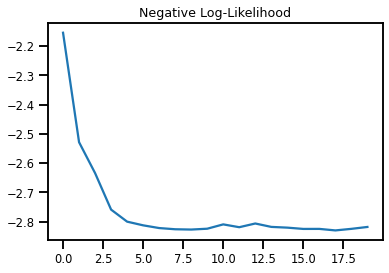

In [49]:

plt.figure()
plt.plot(nll_losses)
plt.title('Negative Log-Likelihood')
plt.show()

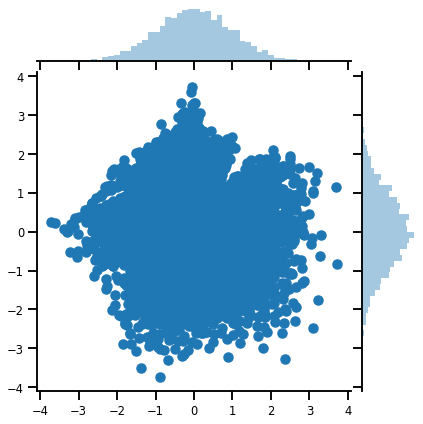

In [40]:
sns.jointplot(Xtrans[:, 0], Xtrans[:, 1])

### Log Probability

In [41]:
latent_prob = jax.scipy.stats.norm.logpdf(Xtrans)

log_prob = (latent_prob + X_ldj).sum(-1)

### Visualization

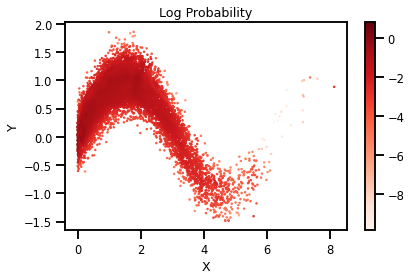

In [42]:
cmap = "Reds"
probs = log_prob
# probs = np.clip(probs, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

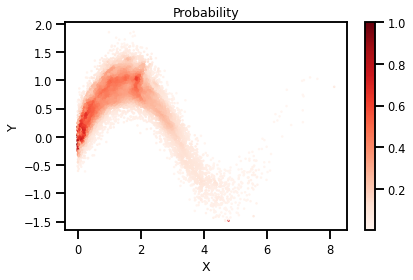

In [43]:
cmap = "Reds"
probs = np.exp(log_prob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Log Likelihood

In [44]:
nll = -(latent_prob + X_ldj).sum(1).mean()
print(nll)

1.4995167207572555
